In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [91]:
from abc import abstractmethod
import torch
from torch import Tensor, nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

# Muon generation

In [15]:
def generate_batch(n:int) -> Tensor:
    r'''
    Return tensor is (muons, coords),
    coords = (x~Uniform[0,1], y~Uniform[0,1], z=1, p=100GeV, theta~cos2(a) a~Uniform[0,0.5pi], phi~Uniform[0,2pi])
    '''
    
    batch = torch.ones(n,6)
    batch[:,0] = torch.rand(n)
    batch[:,1] = torch.rand(n)    
    batch[:,3] = 100
    batch[:,4] = torch.clamp_max(torch.abs(torch.randn(n)/10),math.pi/2)
    batch[:,5] = torch.rand(n)*2*math.pi
    return batch

In [16]:
x = generate_batch(10000)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


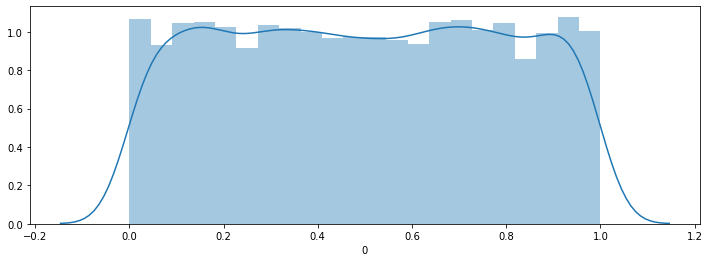

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


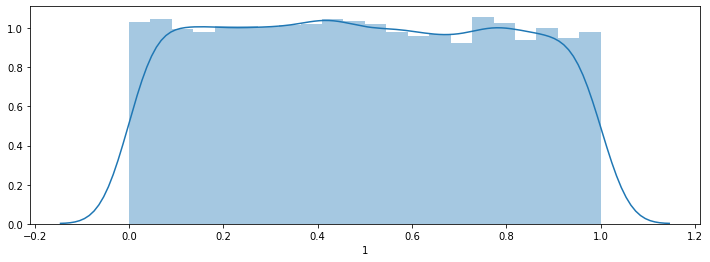

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


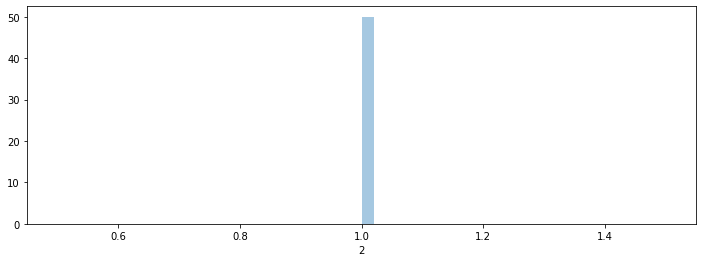

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/giles/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


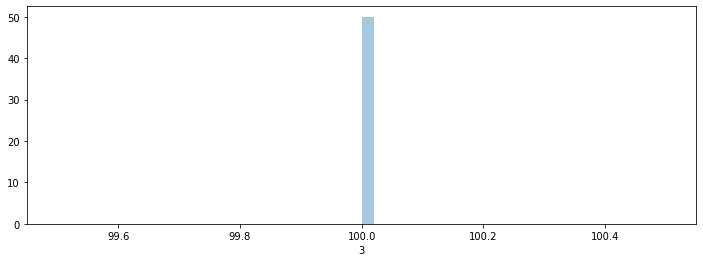

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


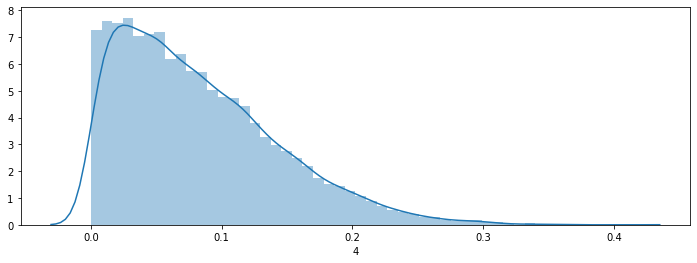

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


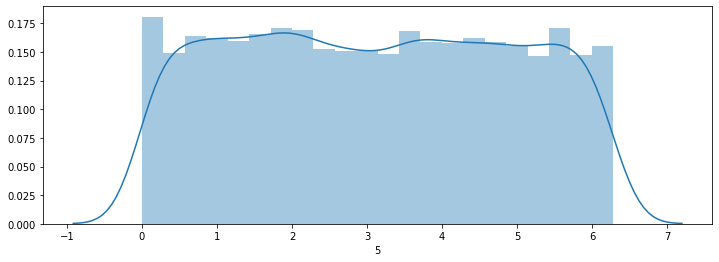

In [18]:
for i in range(x.shape[1]):
    plt.figure(figsize=(12,4))
    sns.distplot(x[:,i])
    plt.xlabel(i)
    plt.show()

# Volume+Detector

In [107]:
class Layer(nn.Module):
    def __init__(self, lw:Tensor, z:float, size:float, device:torch.device):
        super().__init__()
        self.lw,self.z,self.device = Tensor(lw),Tensor(z),device
        
    def abs2idx(self, x:Tensor) -> Tensor:
        return torch.floor(x/self.size)
    
    def propagate_half(self, x:Tensor) -> Tensor:
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:z=1, 3:p=100GeV, 4:theta~cos2(a) a~Uniform[0,0.5pi], 5:phi~Uniform[0,2pi])
        '''
        
        x[:,0] = x[:,0]+(torch.sin(x[:,4])*torch.cos(x[:,5]*self.size/2))
        x[:,1] = x[:,1]+(torch.sin(x[:,4])*torch.sin(x[:,5]*self.size/2))
        return x
                         
    @abstractmethod
    def forward(self, x:Tensor) -> Tuple[Tensor,Optional[Tensor],Optional[Tensor]]: pass  # muons, hits, traversed voxels

## Volume

In [104]:
def arb_density(z:float, lw:Tensor, size:float) -> float:
    density = torch.ones(list((lw/size).astype('int')))
    if z >= 3 and z <= 6: density[3:7,3:7] = 50
    return density

In [110]:
d = arb_density(3, lw=np.array([1,1]), size=0.1);d

tensor([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1., 50., 50., 50., 50.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [112]:
x = generate_batch(10)

In [116]:
idxs = torch.floor(x[:,:2]/0.1).long()

In [117]:
idxs

tensor([[4, 7],
        [9, 0],
        [3, 3],
        [4, 1],
        [3, 7],
        [3, 3],
        [6, 6],
        [6, 9],
        [2, 0],
        [5, 1]])

In [109]:
class VolumeLayer(Layer):
    def __init__(self, density_func:Callable[[float,Tensor,float],float],
                 lw:Tensor, z:float, size:float, device:torch.device):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.density = density_func(self.z, self.lw, size=self.size).to(self.device)
        
    def multi_scatter(self, x:Tensor, xy_idx:Tensor) -> Tensor:
        r'''
        coords = (0:x~Uniform[0,1], 1:y~Uniform[0,1], 2:z=1, 3:p=100GeV, 4:theta~cos2(a) a~Uniform[0,0.5pi], 5:phi~Uniform[0,2pi])
        '''
        
        x[:,5] = x[:,5] + torch.randn(len(x))
        x[:,4] = x[:,4]#+(torch.randn(len(x))*self.density_func/1000)
        return x
        
    def forward(self, x:Tensor) -> Tuple[Tensor,None,Tensor]:
        x = self.propagate_half(x)
        xy_idx = self.abs2idx(x[:,:2])
        x = self.multi_scatter(x, xy_idx)
        x = self.propagate_half(x)
        return x, None, xy_idx

## Detector

In [97]:
class DetectorLayer(Layer):
    def __init__(self, init_res:float, init_eff:float, lw:Tuple[float,float], z:float, size:float, device:torch.device):
        super().__init__(lw=lw, z=z, size=size, device=device)
        self.resolution = torch.zeros_like((lw/size), device=self.device)+self.init_res
        self.efficiency = torch.zeros_like((lw/size), device=self.device)+self.init_eff
        
    def get_hits(self, x:Tensor) -> Tensor:  # to dense and add precision
        det = torch.rand(len(x)) < self.efficiency
        pos = torch.stack([torch.randn(len(x[det,0]))*self.resolution+x[:,0],
                           torch.randn(len(x[det,1]))*self.resolution+x[:,1],
                           x[det,2]], dim=1)
        return pos
        
    def forward(self, x:Tensor) -> Tuple[Tensor,Tensor,None]:
        x = self.propagate_half(x)
        hits = self.get_hits(x)
        x = self.propagate_half(x)
        return x, hits,None

## Propagator 

In [ ]:
class Propagator(nn.Module):
    def __init__(self, lwh:Tuple[float,float,float], size:float, detectors:List[bool],
                 density_func:Callable[[float, torch.Tensor, float]], init_res:float, init_eff:float, device:torch.device):
        super().__init__()
        self.lwh,self.size = Tensor(lwh),size
        self.z = list(reversed(range(int(self.lwh[2]))))
        self.density_func = density_func
        if len(detectors) != len(self.z): raise ValueError("Length of detector must match number of z-layers")
        self.layers = self._get_layers()
        
    def _get_layers(self) -> nn.ModuleList:
        layers = []
        for z,d in zip(self.z,self.detectors):
            if d:
                layers.append(DetectorLayer(self.init_res, self.init_eff, lw=self.lwh[:2], z=z, size=self.size, device=self.device))
            else:
                layers.append(VolumeLayer(self.density_func, lw=self.lwh[:2], z=z, size=self.size, device=self.device))
        return nn.ModuleList(layers)
    
    def prune(self, x:Tensor) -> Tensor:
        x = x[x[:,0] >= 0]
        x = x[x[:,0] < self.lw[0]]
        x = x[x[:,1] >= 0]
        x = x[x[:,1] < self.lw[1]]
        return x
        
    def forward(self, x:Tensor) -> Tensor:
        hits,voxels = [],[]
        for l in self.layers:
            x,h,v = l(x)
            if h is not None: hits.append(h)
            if v is not None: voxels.append(v)
            x = self.prune(x)
#         hits = torch.cat(hits, dim=1) hits are dense
#         cat voxels
        return hits,voxels